In [ ]:
!pip install kagglehub

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Get the dataset
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

# Load data
data = pd.read_csv(path + "/styles.csv", on_bad_lines='skip')

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nSample of unique categories:")
print(data['masterCategory'].value_counts().head())

100%|██████████| 565M/565M [00:09<00:00, 64.9MB/s]

Extracting files...


Dataset Shape: (44424, 10)

Columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

Sample of unique categories:
masterCategory
Apparel          21397
Accessories      11274
Footwear          9219
Personal Care     2403
Free Items         105
Name: count, dtype: int64


In [ ]:
def prepare_features(data):
    """Prepare features for the model"""
    # Select relevant features
    feature_columns = ['baseColour', 'usage', 'season', 'year', 'subCategory']
    features = data[feature_columns].copy()

    # Handle missing values
    features = features.fillna('missing')

    # Convert year to string to ensure uniform type
    features['year'] = features['year'].astype(str)

    # Encode categorical variables
    encoders = {}
    for column in features.columns:
        encoders[column] = LabelEncoder()
        features[column] = encoders[column].fit_transform(features[column])

    return features, encoders

def prepare_targets(data):
    """Prepare target variables"""
    target_encoders = {}
    targets = pd.DataFrame()

    for col in ['masterCategory', 'baseColour', 'articleType']:
        target_encoders[col] = LabelEncoder()
        targets[f'{col}_encoded'] = target_encoders[col].fit_transform(data[col])

    return targets, target_encoders

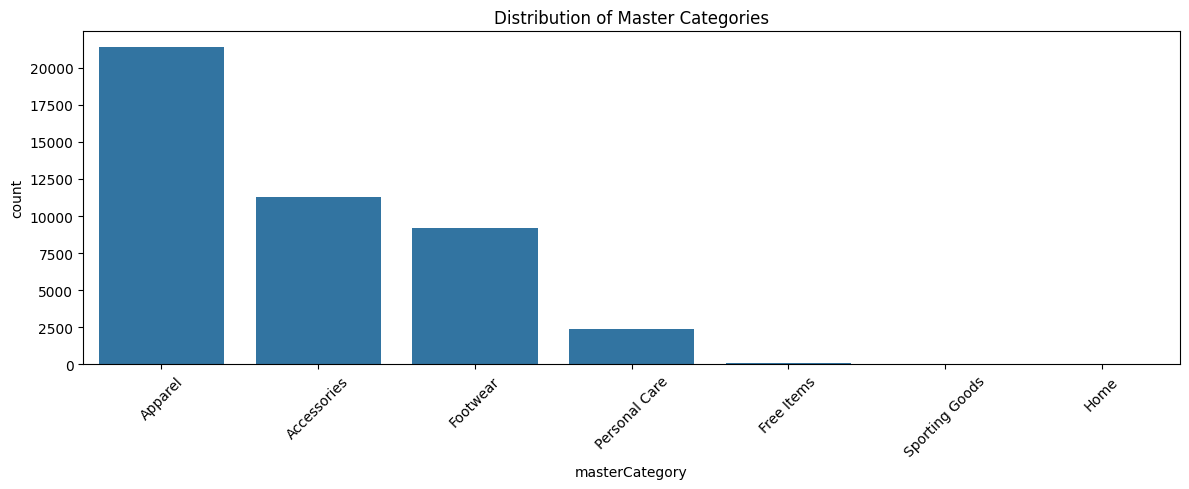


Master Category Distribution:
masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


In [ ]:
# Analyze class distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=data, x='masterCategory', order=data['masterCategory'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Master Categories')
plt.tight_layout()
plt.show()

# Display value counts
print("\nMaster Category Distribution:")
print(data['masterCategory'].value_counts())

In [ ]:
def train_evaluate_svm(features, targets, test_size=0.2, sample_size=None):
    """Train and evaluate SVM model"""
    # Optionally use subset of data
    if sample_size is not None:
        indices = np.random.choice(features.index, sample_size, replace=False)
        features = features.loc[indices]
        targets = targets.loc[indices]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, test_size=test_size, random_state=42,
        stratify=targets['masterCategory_encoded']
    )

    # Create pipeline
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
    ])

    # Create multi-output classifier
    multi_target_model = MultiOutputClassifier(svm_pipeline)

    print("Training SVM model...")
    multi_target_model.fit(X_train, y_train)

    print("Making predictions...")
    y_pred = multi_target_model.predict(X_test)

    # Evaluate results
    results = {}
    print("\nModel Evaluation:")
    for i, col in enumerate(['masterCategory', 'baseColour', 'articleType']):
        print(f"\nClassification Report for {col}:")
        report = classification_report(y_test.iloc[:, i], y_pred[:, i])
        print(report)

        accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"Accuracy for {col}: {accuracy:.3f}")

        results[col] = {
            'accuracy': accuracy,
            'report': report
        }

    return multi_target_model, X_test, y_test, results

In [ ]:
# Prepare features and targets
features, feature_encoders = prepare_features(data)
targets, target_encoders = prepare_targets(data)

# Train model with sample of data
sample_size = 10000  # Adjust based on your computational resources
model, X_test, y_test, results = train_evaluate_svm(features, targets, sample_size=sample_size)

Training SVM model...
Making predictions...

Model Evaluation:

Classification Report for masterCategory:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       523
           1       0.88      0.94      0.91       955
           2       0.89      0.90      0.90       414
           3       0.00      0.00      0.00         4
           5       0.96      1.00      0.98       103
           6       0.00      0.00      0.00         1

    accuracy                           0.88      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.88      0.88      0.88      2000

Accuracy for masterCategory: 0.881

Classification Report for baseColour:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.65      0.99      0.78       419
           2       0.61      0.12      0.20       223
           3       0.00      0.00      0.00         4
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

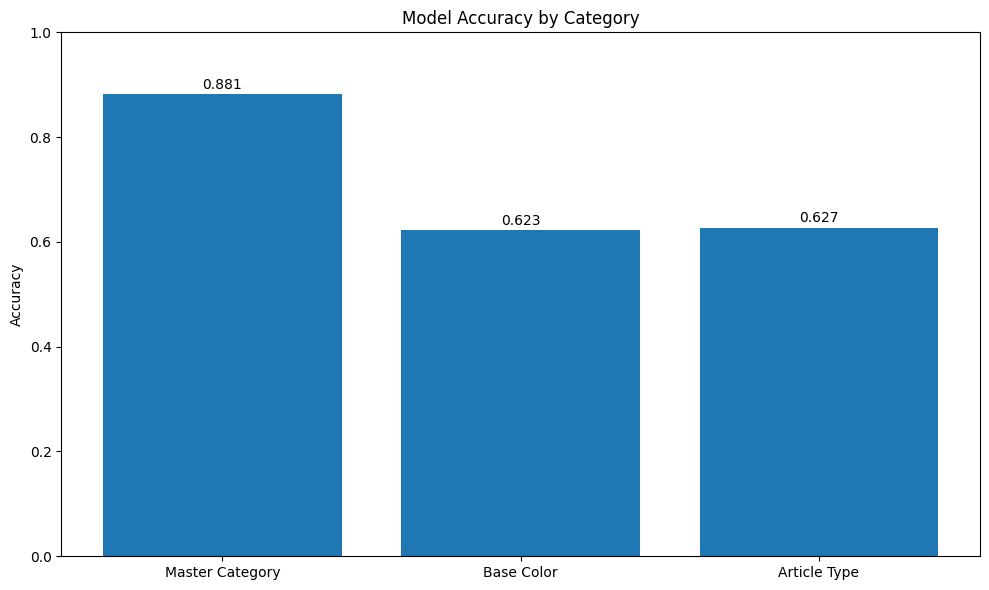

In [ ]:
# Plot accuracy comparison
accuracies = [results[col]['accuracy'] for col in ['masterCategory', 'baseColour', 'articleType']]
plt.figure(figsize=(10, 6))
plt.bar(['Master Category', 'Base Color', 'Article Type'], accuracies)
plt.title('Model Accuracy by Category')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
def predict_single_item(model, feature_encoders, target_encoders, item_features):
    """Predict categories for a single fashion item"""
    # Prepare features
    encoded_features = {}
    for col, value in item_features.items():
        if col in feature_encoders:
            try:
                encoded_features[col] = feature_encoders[col].transform([value])[0]
            except:
                encoded_features[col] = feature_encoders[col].transform(['missing'])[0]

    # Convert to array
    feature_array = np.array([[encoded_features[col] for col in feature_encoders.keys()]])

    # Make predictions
    predictions = model.predict(feature_array)

    # Decode predictions
    results = {}
    for i, (target, encoder) in enumerate(target_encoders.items()):
        predicted_class = encoder.inverse_transform([predictions[0][i]])[0]
        results[target] = predicted_class

    return results

In [ ]:
# Example prediction
sample_item = {
    'baseColour': 'Black',
    'usage': 'Casual',
    'season': 'Summer',
    'year': 2020,
    'subCategory': 'Topwear'
}

prediction = predict_single_item(model, feature_encoders, target_encoders, sample_item)
print("\nPredictions for sample item:")
for category, prediction in prediction.items():
    print(f"{category}: {prediction}")


Predictions for sample item:
masterCategory: Accessories
baseColour: Black
articleType: Casual Shoes


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


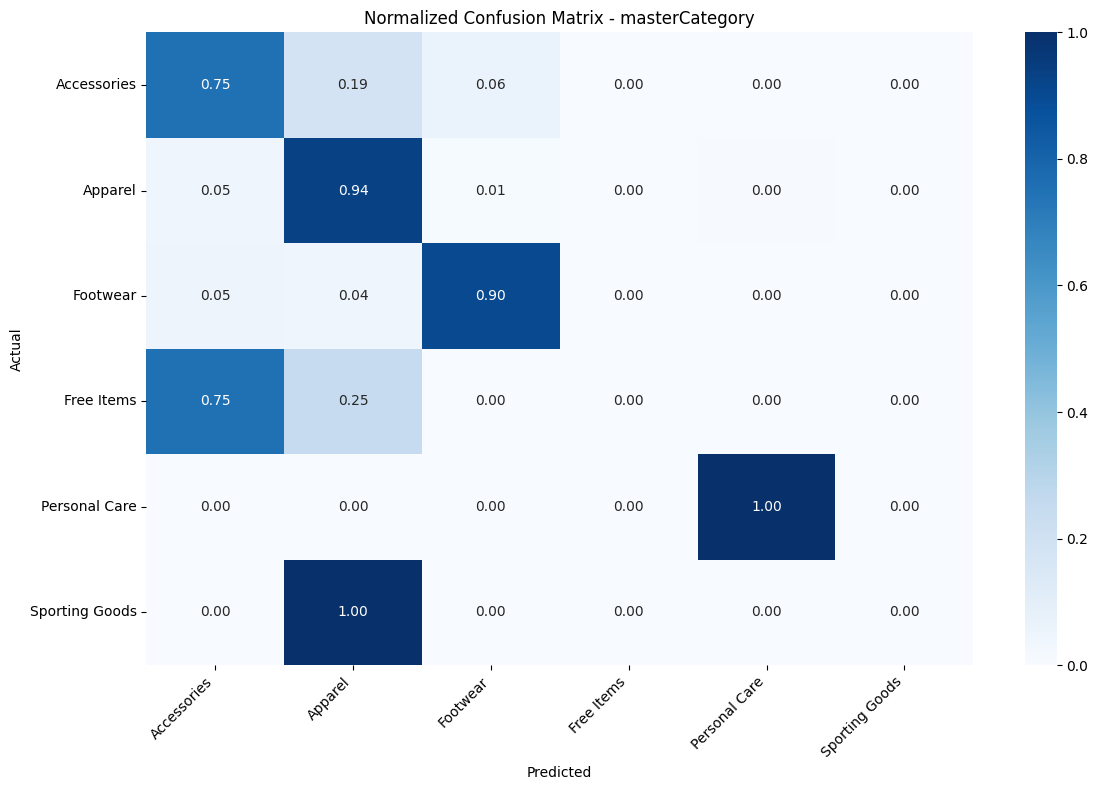


Detailed Confusion Matrix for masterCategory:

Raw counts:
                Accessories  Apparel  Footwear  Free Items  Personal Care  \
Accessories             393       97        33           0              0   
Apparel                  47      893        11           0              4   
Footwear                 22       18       374           0              0   
Free Items                3        1         0           0              0   
Personal Care             0        0         0           0            103   
Sporting Goods            0        1         0           0              0   

                Sporting Goods  
Accessories                  0  
Apparel                      0  
Footwear                     0  
Free Items                   0  
Personal Care                0  
Sporting Goods               0  




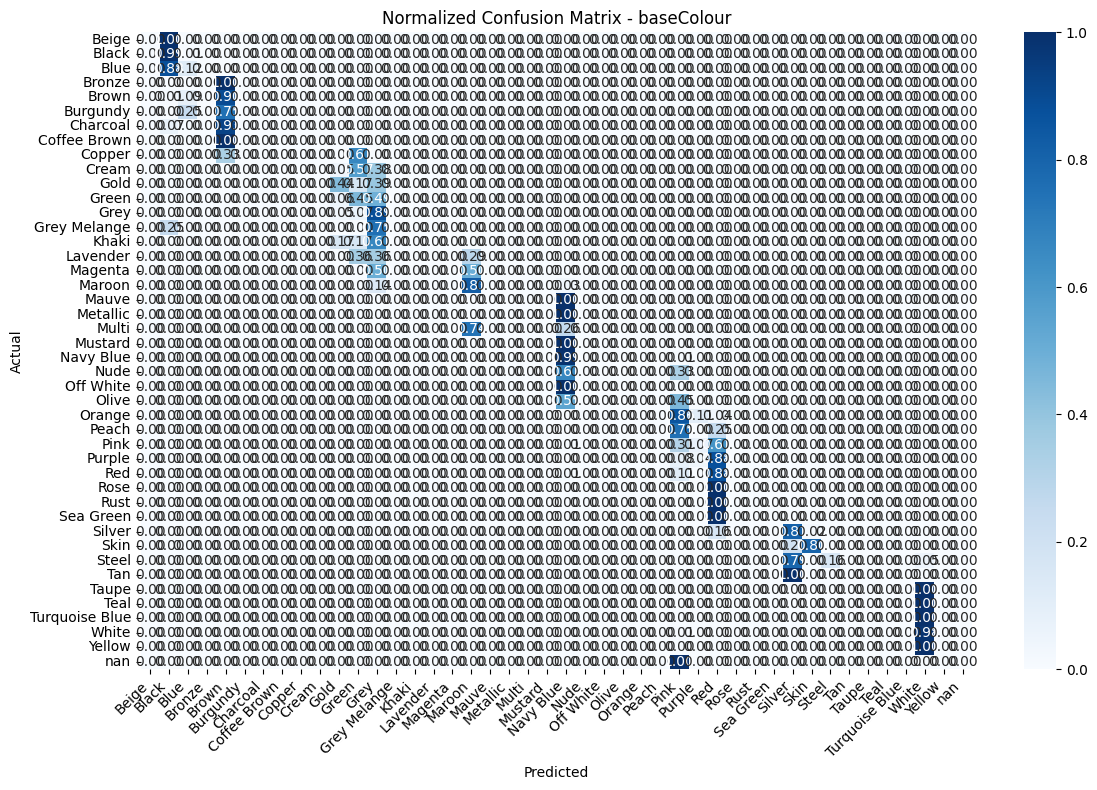


Detailed Confusion Matrix for baseColour:

Raw counts:
                Beige  Black  Blue  Bronze  Brown  Burgundy  Charcoal  \
Beige               0     26     0       0      0         0         0   
Black               0    416     3       0      0         0         0   
Blue                0    196    27       0      0         0         0   
Bronze              0      0     0       0      4         0         0   
Brown               0      2    13       0    132         0         0   
Burgundy            0      0     1       0      3         0         0   
Charcoal            0      1     0       0     13         0         0   
Coffee Brown        0      0     0       0      3         0         0   
Copper              0      0     0       0      1         0         0   
Cream               0      0     0       0      0         0         0   
Gold                0      0     0       0      0         0         0   
Green               0      0     0       0      0         0         

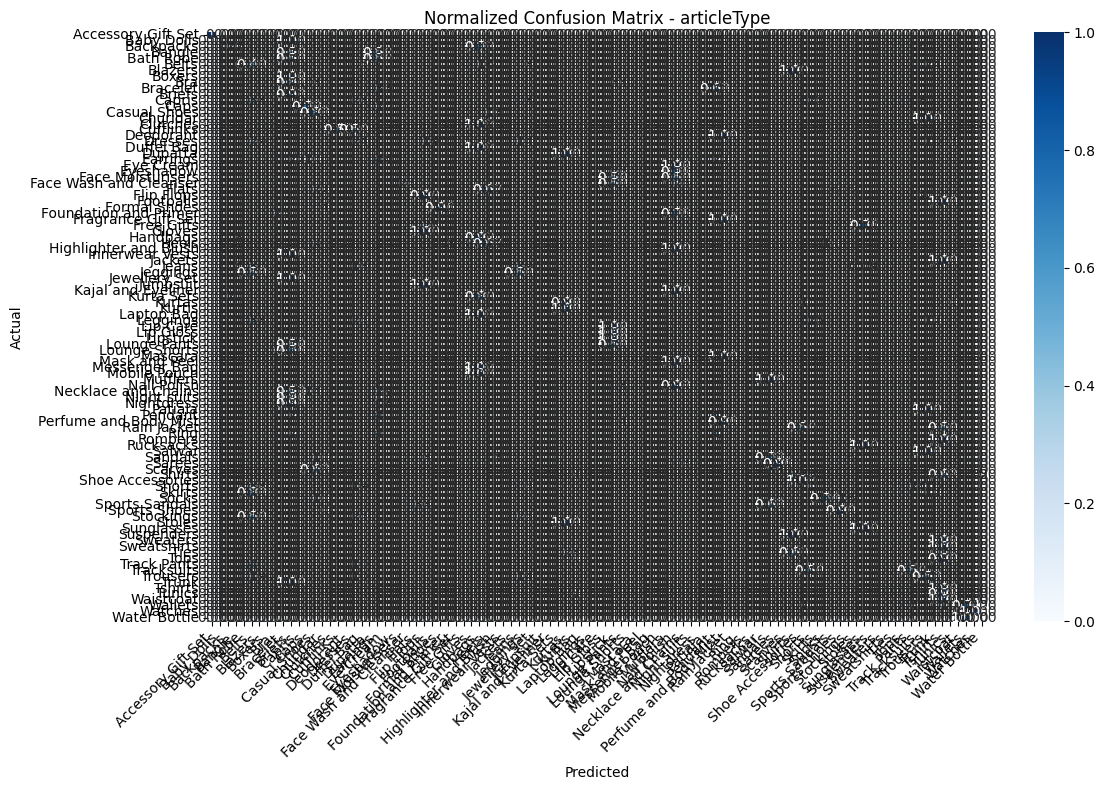


Detailed Confusion Matrix for articleType:

Raw counts:
                    Accessory Gift Set  Baby Dolls  Backpacks  Bangle  \
Accessory Gift Set                   3           0          0       0   
Baby Dolls                           0           0          0       0   
Backpacks                            0           0          8       0   
Bangle                               0           0          0       0   
Bath Robe                            0           0          0       0   
...                                ...         ...        ...     ...   
Tunics                               0           0          0       0   
Waistcoat                            0           0          0       0   
Wallets                              0           0          0       0   
Watches                              0           0          0       0   
Water Bottle                         0           0          0       0   

                    Bath Robe  Belts  Blazers  Boxers  Bra  Bracel

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for test set
y_pred = model.predict(X_test)

categories = ['masterCategory', 'baseColour', 'articleType']

for i, category in enumerate(categories):
   # Get actual and predicted labels
   y_true = y_test.iloc[:, i]
   y_pred_category = y_pred[:, i]

   # Get unique classes that actually appear in both true and predicted labels
   unique_classes = np.unique(np.concatenate([y_true, y_pred_category]))
   labels = target_encoders[category].inverse_transform(unique_classes)

   # Create confusion matrix
   cm = confusion_matrix(y_true, y_pred_category, labels=unique_classes)

   # Normalize confusion matrix
   cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   # Create figure with appropriate size based on number of classes
   plt.figure(figsize=(12, 8))

   # Plot heatmap
   sns.heatmap(cm_normalized,
               annot=True,
               fmt='.2f',
               cmap='Blues',
               xticklabels=labels,
               yticklabels=labels)

   plt.title(f'Normalized Confusion Matrix - {category}')
   plt.xlabel('Predicted')
   plt.ylabel('Actual')

   # Rotate labels and adjust layout based on label length
   max_label_length = max(len(str(label)) for label in labels)
   rotation = 45 if max_label_length > 8 else 0

   plt.xticks(rotation=rotation, ha='right' if rotation > 0 else 'center')
   plt.yticks(rotation=0)

   # Adjust layout to prevent label cutoff
   plt.tight_layout()
   plt.show()

   # Print raw numbers
   print(f"\nDetailed Confusion Matrix for {category}:")
   cm_df = pd.DataFrame(cm,
                       index=labels,
                       columns=labels)
   print("\nRaw counts:")
   print(cm_df)
   print("\n" + "="*80 + "\n")  # Add separator between matrices